In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial,freesans'

import numpy as np
import pandas as pd
import pathlib
import xarray as xr
import time
import os
import sys
import necstdb
sys.path.append('/home/amigos/otf_yamada/_python_modules/analy_n2data/script')
from datetime import datetime
import datetime as dt
import matplotlib.dates as md
import cv2

In [2]:
path = '/mnt/usbdisk9/data/observation/otf/otf_2019/n20200320193251_12CO_2-1_otf_OriKL'

In [4]:
#path = '/mnt/usbdisk9/data/observation/otf_planet2018/n20200320150852_12CO_2-1_otfplanet_jupiter'

In [3]:
xFFTS_Data_topics = [
    
    'xffts_board01',
    'xffts_board02',
    'xffts_board03',
    'xffts_board04',
    'xffts_board05',
    'xffts_board06',
    'xffts_board07',
    'xffts_board08',
    'xffts_board09',
    'xffts_board10',
    'xffts_board11',
    'xffts_board12',
    'xffts_board13',
    'xffts_board14',
    'xffts_board15',
    'xffts_board16'
    
]

In [4]:
beamname = {
'ac240_spectra_data_1': 'Beam1 - LL',
'ac240_spectra_data_2': 'Beam1 - LU',
'xffts_board01': 'Beam2 - LU',
'xffts_board02': 'Beam2 - LL',
'xffts_board03': 'Beam2 - RU',
'xffts_board04': 'Beam2 - RL',
'xffts_board05': 'Beam3 - LU',
'xffts_board06': 'Beam3 - LL',
'xffts_board07': 'Beam3 - RU',
'xffts_board08': 'Beam3 - RL',
'xffts_board09': 'Beam4 - LU',
'xffts_board10': 'Beam4 - LL',
'xffts_board11': 'Beam4 - RU',
'xffts_board12': 'Beam4 - RL',
'xffts_board13': 'Beam5 - LU',
'xffts_board14': 'Beam5 - LL',
'xffts_board15': 'Beam5 - RU',
'xffts_board16': 'Beam5 - RL'
}

In [5]:
#山田さんスクリプト
#otfデータ,obsモードなどをxarrayにまとめてくれる

def get_array(path, xFFTS_Data_topics):
    db = necstdb.opendb(path)
    xFFTS_data = db.open_table(xFFTS_Data_topics).read(astype='array')
    obsmode =  db.open_table('obsmode').read(astype='array')
    enc =  db.open_table('status_encoder').read(astype='array')
    
    spec_array = xr.DataArray(

        xFFTS_data['spec'], 
        dims=['t', 'spectral_data'], 
        coords={'t':xFFTS_data['received_time']}
    )


    obsmode_array = xr.DataArray(

        obsmode['obs_mode'],
        dims = ['t'],
        coords={'t':obsmode['received_time'], 'scan_num':('t', obsmode['scan_num'])}


    )
    
    az_array = xr.DataArray(
        
        enc['enc_az']/3600, 
        dims=['t'],
        coords={'t':enc['timestamp']}
    )
    
    el_array = xr.DataArray(
        
        enc['enc_el']/3600, 
        dims=['t'],
        coords={'t':enc['timestamp']}
    )

    return spec_array, obsmode_array, az_array, el_array

def concatenate(spec_array, obsmode_array, az_array, el_array):
    
    reindexed_obsmode_array = obsmode_array.reindex(t=spec_array['t'], method='backfill')
    reindexed_encoder_az_array = az_array.interp_like(spec_array)
    reindexed_encoder_el_array = el_array.interp_like(spec_array)
    
    del obsmode_array
    del az_array
    del el_array
    raw_array = xr.DataArray(
        np.array(spec_array),
        dims=['t', 'spectral_data'],
        coords={'t':spec_array['t'],
                
               'obsmode':('t',np.array(reindexed_obsmode_array)),
               'scan_num':('t', np.array(reindexed_obsmode_array['scan_num'])),
               'azlist':('t', np.array(reindexed_encoder_az_array)),
               'ellist':('t', np.array(reindexed_encoder_el_array))
                
               }
    )
    
    return raw_array

In [6]:
#全てのデータを取り出し、時間を軸に追加
def all_data(path,*args):
    data_dict = {}
    for topic in args:
        data=concatenate(*get_array(path, topic))
        timearray = [dt.datetime.fromtimestamp(ts) for ts in data['t'].values]
        data_array = data.assign_coords(time=("t", timearray))
        data_on_vs_time = data_array.swap_dims({"t":"time"})
        data_on_vs_time.name = topic+" : "+beamname[topic]
        data_dict[topic] = data_on_vs_time
        
    return data_dict

In [18]:
#on点のみを取り出し時間を追加

def select_data_on(path, *args):
    data_dict = {}
    for topic in args:
        data = concatenate(*get_array(path, topic))
        data_on = data.where(data.obsmode==b'ON        ' , drop= True)
        timearray = [dt.datetime.fromtimestamp(ts) for ts in data_on['t'].values]
        data_array = data_on.assign_coords(time=("t", timearray))
        data_on_vs_time = data_array.swap_dims({"t":"time"})
        data_on_vs_time.name = topic+" : "+beamname[topic]+" OTF-ON"
        data_dict[topic] = data_on_vs_time
        
    return data_dict

In [19]:
#off点
def select_data_off(path, *args):
    data_dict = {}
    for topic in args:
        data=concatenate(*get_array(path, topic))
        data_on=data.where(data.obsmode==b'OFF       ' , drop= True)
        timearray = [dt.datetime.fromtimestamp(ts) for ts in data_on['t'].values]
        data_array = data_on.assign_coords(time=("t", timearray))
        data_on_vs_time = data_array.swap_dims({"t":"time"})
        data_on_vs_time.name = topic+" : "+beamname[topic]+" OTF-OFF"
        data_dict[topic] = data_on_vs_time
        
    return data_dict

In [7]:
#hot点
def select_data_hot(path, *args):
    data_dict = {}
    for topic in args:
        data=concatenate(*get_array(path, topic))
        data_on=data.where(data.obsmode==b'HOT       ' , drop= True)
        timearray = [dt.datetime.fromtimestamp(ts) for ts in data_on['t'].values]
        data_array = data_on.assign_coords(time=("t", timearray))
        data_on_vs_time = data_array.swap_dims({"t":"time"})
        data_on_vs_time.name = topic+" : "+beamname[topic]+" OTF-HOT"
        data_dict[topic] = data_on_vs_time
        
    return data_dict

In [7]:
data = all_data(path,'xffts_board01','xffts_board02','xffts_board03','xffts_board04')

Text(0.5, 0.98, '/mnt/usbdisk9/data/observation/otf_planet2018/n20200320150852_12CO_2-1_otfplanet_jupiter')

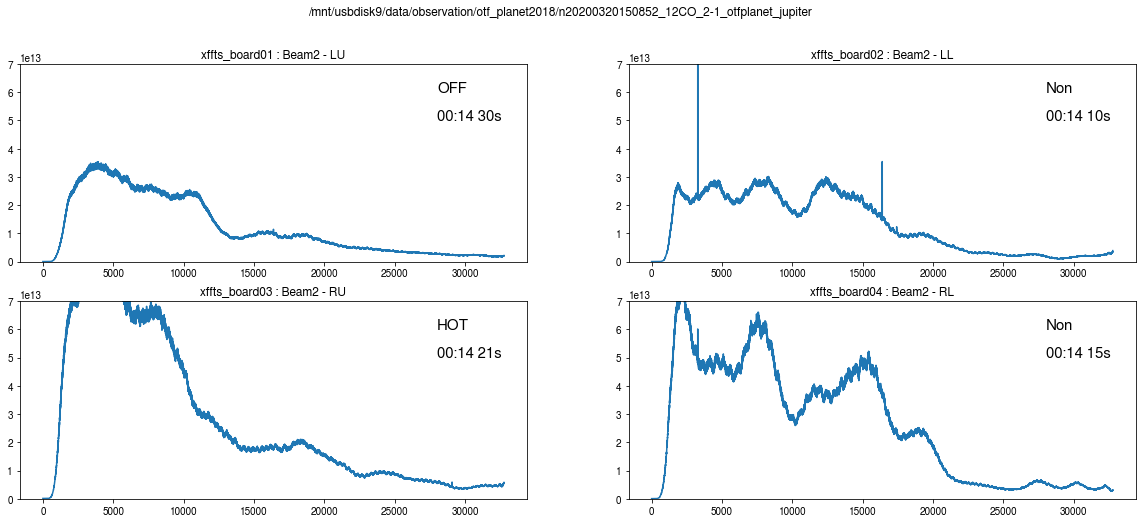

In [62]:
#data = all_data(path,'xffts_board01','xffts_board02','xffts_board03','xffts_board04')

mainfig = plt.figure(figsize=(20,8))

ax_list = [mainfig.add_subplot(2,2,i+1) for i in range(4)]
num=1600
for ax, tup in zip(ax_list, data.items()):
    key,value = tup
    ax.plot(value[num])
    ax.set_ylim(0,10e13)
    
    time_64 = value[num]['time'].values
    time_pd = pd.to_datetime(time_64)
    time = time_pd.strftime('%H:%M %S.%f')
    ax.text(28000,5e13,time,fontsize=15)
    ax.set_title(value.name)
    
    obs = value[num]['obsmode'].values
    if obs == b'Non       ' :
        obs_text = 'Non'
    elif obs == b'ON        ' :
        obs_text = 'ON'
    elif obs == b'OFF       ' :
        obs_text = 'OFF'
    elif obs == b'HOT       ' :
        obs_text = 'HOT'
    else:
        obs_text = obs
    
    ax.text(28000,6e13,obs_text,fontsize=15)
    
mainfig.suptitle(path)

In [22]:
#グラフ作成　保存(all data)
#data = all_data(path,'xffts_board01','xffts_board02','xffts_board03','xffts_board04')

def make_fig_all(data,num,fnum):
    mainfig = plt.figure(figsize=(20,8))

    ax_list = [mainfig.add_subplot(2,2,i+1) for i in range(4)]

    for ax, tup in zip(ax_list, data.items()):
        key,value = tup
        ax.plot(value[num])
        ax.set_ylim(0,10e13)

        time_64 = value[num]['time'].values
        time_pd = pd.to_datetime(time_64)
        time = time_pd.strftime('%H:%M %S.%f')
        ax.text(26000,8e13,time,fontsize=15)
        ax.set_title(value.name)

        obs = value[num]['obsmode'].values
        if obs == b'Non       ' :
            obs_text = 'Non'
        elif obs == b'ON        ' :
            obs_text = 'ON'
        elif obs == b'OFF       ' :
            obs_text = 'OFF'
        elif obs == b'HOT       ' :
            obs_text = 'HOT'
        elif obs == b'          ' :
            obs_text = 'Non'
        else:
            obs_text = obs

        ax.text(26000,9e13,obs_text,fontsize=15)

    mainfig.suptitle(path)
    mainfig.savefig('png/' + str(num-fnum).zfill(4) + '.png')
    plt.close()

In [16]:
make_fig_all(data,1100,1000)

In [23]:
for i in range(1001,2001):
    make_fig(data,i,1000)

In [9]:
data = select_data_hot(path,'xffts_board01','xffts_board02','xffts_board03','xffts_board04')

Text(0.5, 0.98, '/mnt/usbdisk9/data/observation/otf/otf_2019/n20200320193251_12CO_2-1_otf_OriKL')

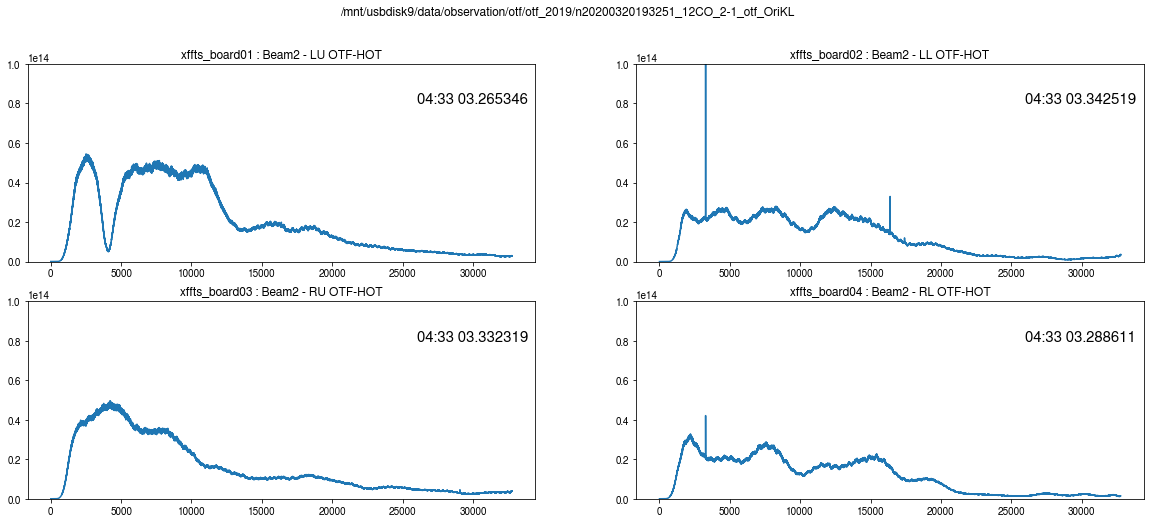

In [12]:
mainfig = plt.figure(figsize=(20,8))

ax_list = [mainfig.add_subplot(2,2,i+1) for i in range(4)]
num = 0
for ax, tup in zip(ax_list, data.items()):
    key,value = tup
    ax.plot(value[num])
    ax.set_ylim(0,10e13)
    
    time_64 = value[num]['time'].values
    time_pd = pd.to_datetime(time_64)
    time = time_pd.strftime('%H:%M %S.%f')
    ax.text(26000,8e13,time,fontsize=15)
    ax.set_title(value.name)
    
mainfig.suptitle(path)

In [13]:
def make_fig_hot(data,num):
    mainfig = plt.figure(figsize=(20,8))

    ax_list = [mainfig.add_subplot(2,2,i+1) for i in range(4)]

    for ax, tup in zip(ax_list, data.items()):
        key,value = tup
        ax.plot(value[num])
        ax.set_ylim(0,10e13)

        time_64 = value[num]['time'].values
        time_pd = pd.to_datetime(time_64)
        time = time_pd.strftime('%H:%M %S.%f')
        ax.text(26000,8e13,time,fontsize=15)
        ax.set_title(value.name)

    mainfig.suptitle(path)
    mainfig.savefig('png/' + str(num).zfill(4) + '.png')
    plt.close()

IndexError: index 666 is out of bounds for axis 0 with size 666

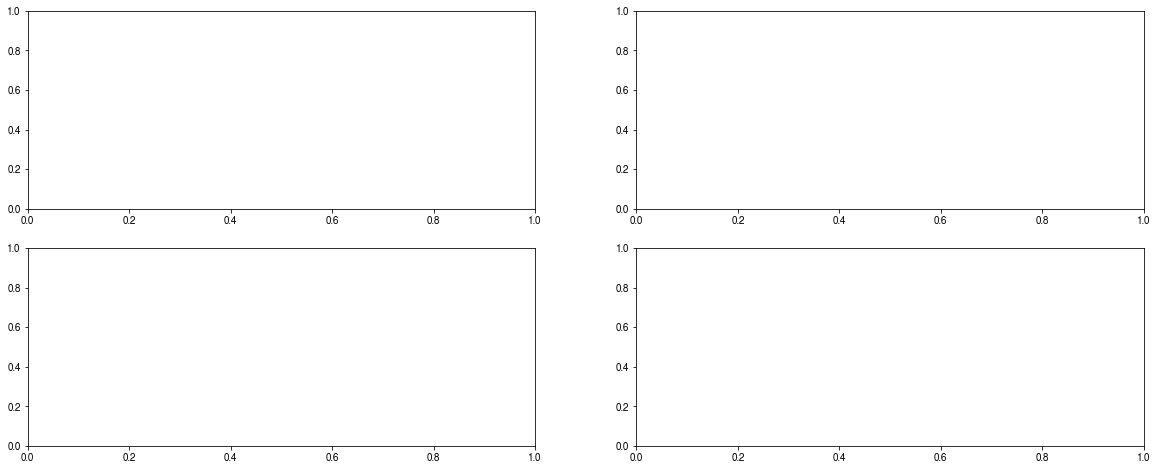

In [16]:
for i in range(0,1000):
    make_fig_hot(data,i)

In [17]:
#opencvで動画作成

# VideoCapture を作成する。
cap = cv2.VideoCapture('png/%04d.png')

# 画像の大きさを取得
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# フレームレートを設定
fps = 20
print('width: {}, height: {}, fps: {}'.format(width, height, fps))

# VideoWriter を作成する。
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter('hot_beam2.mp4', fourcc, fps, (width, height))

while True:
    ret, frame = cap.read()
    if not ret:
        #print("error")
        break  # 映像取得に失敗
    
    writer.write(frame)  # フレームを書き込む。

writer.release()
cap.release()

width: 1440, height: 576, fps: 20


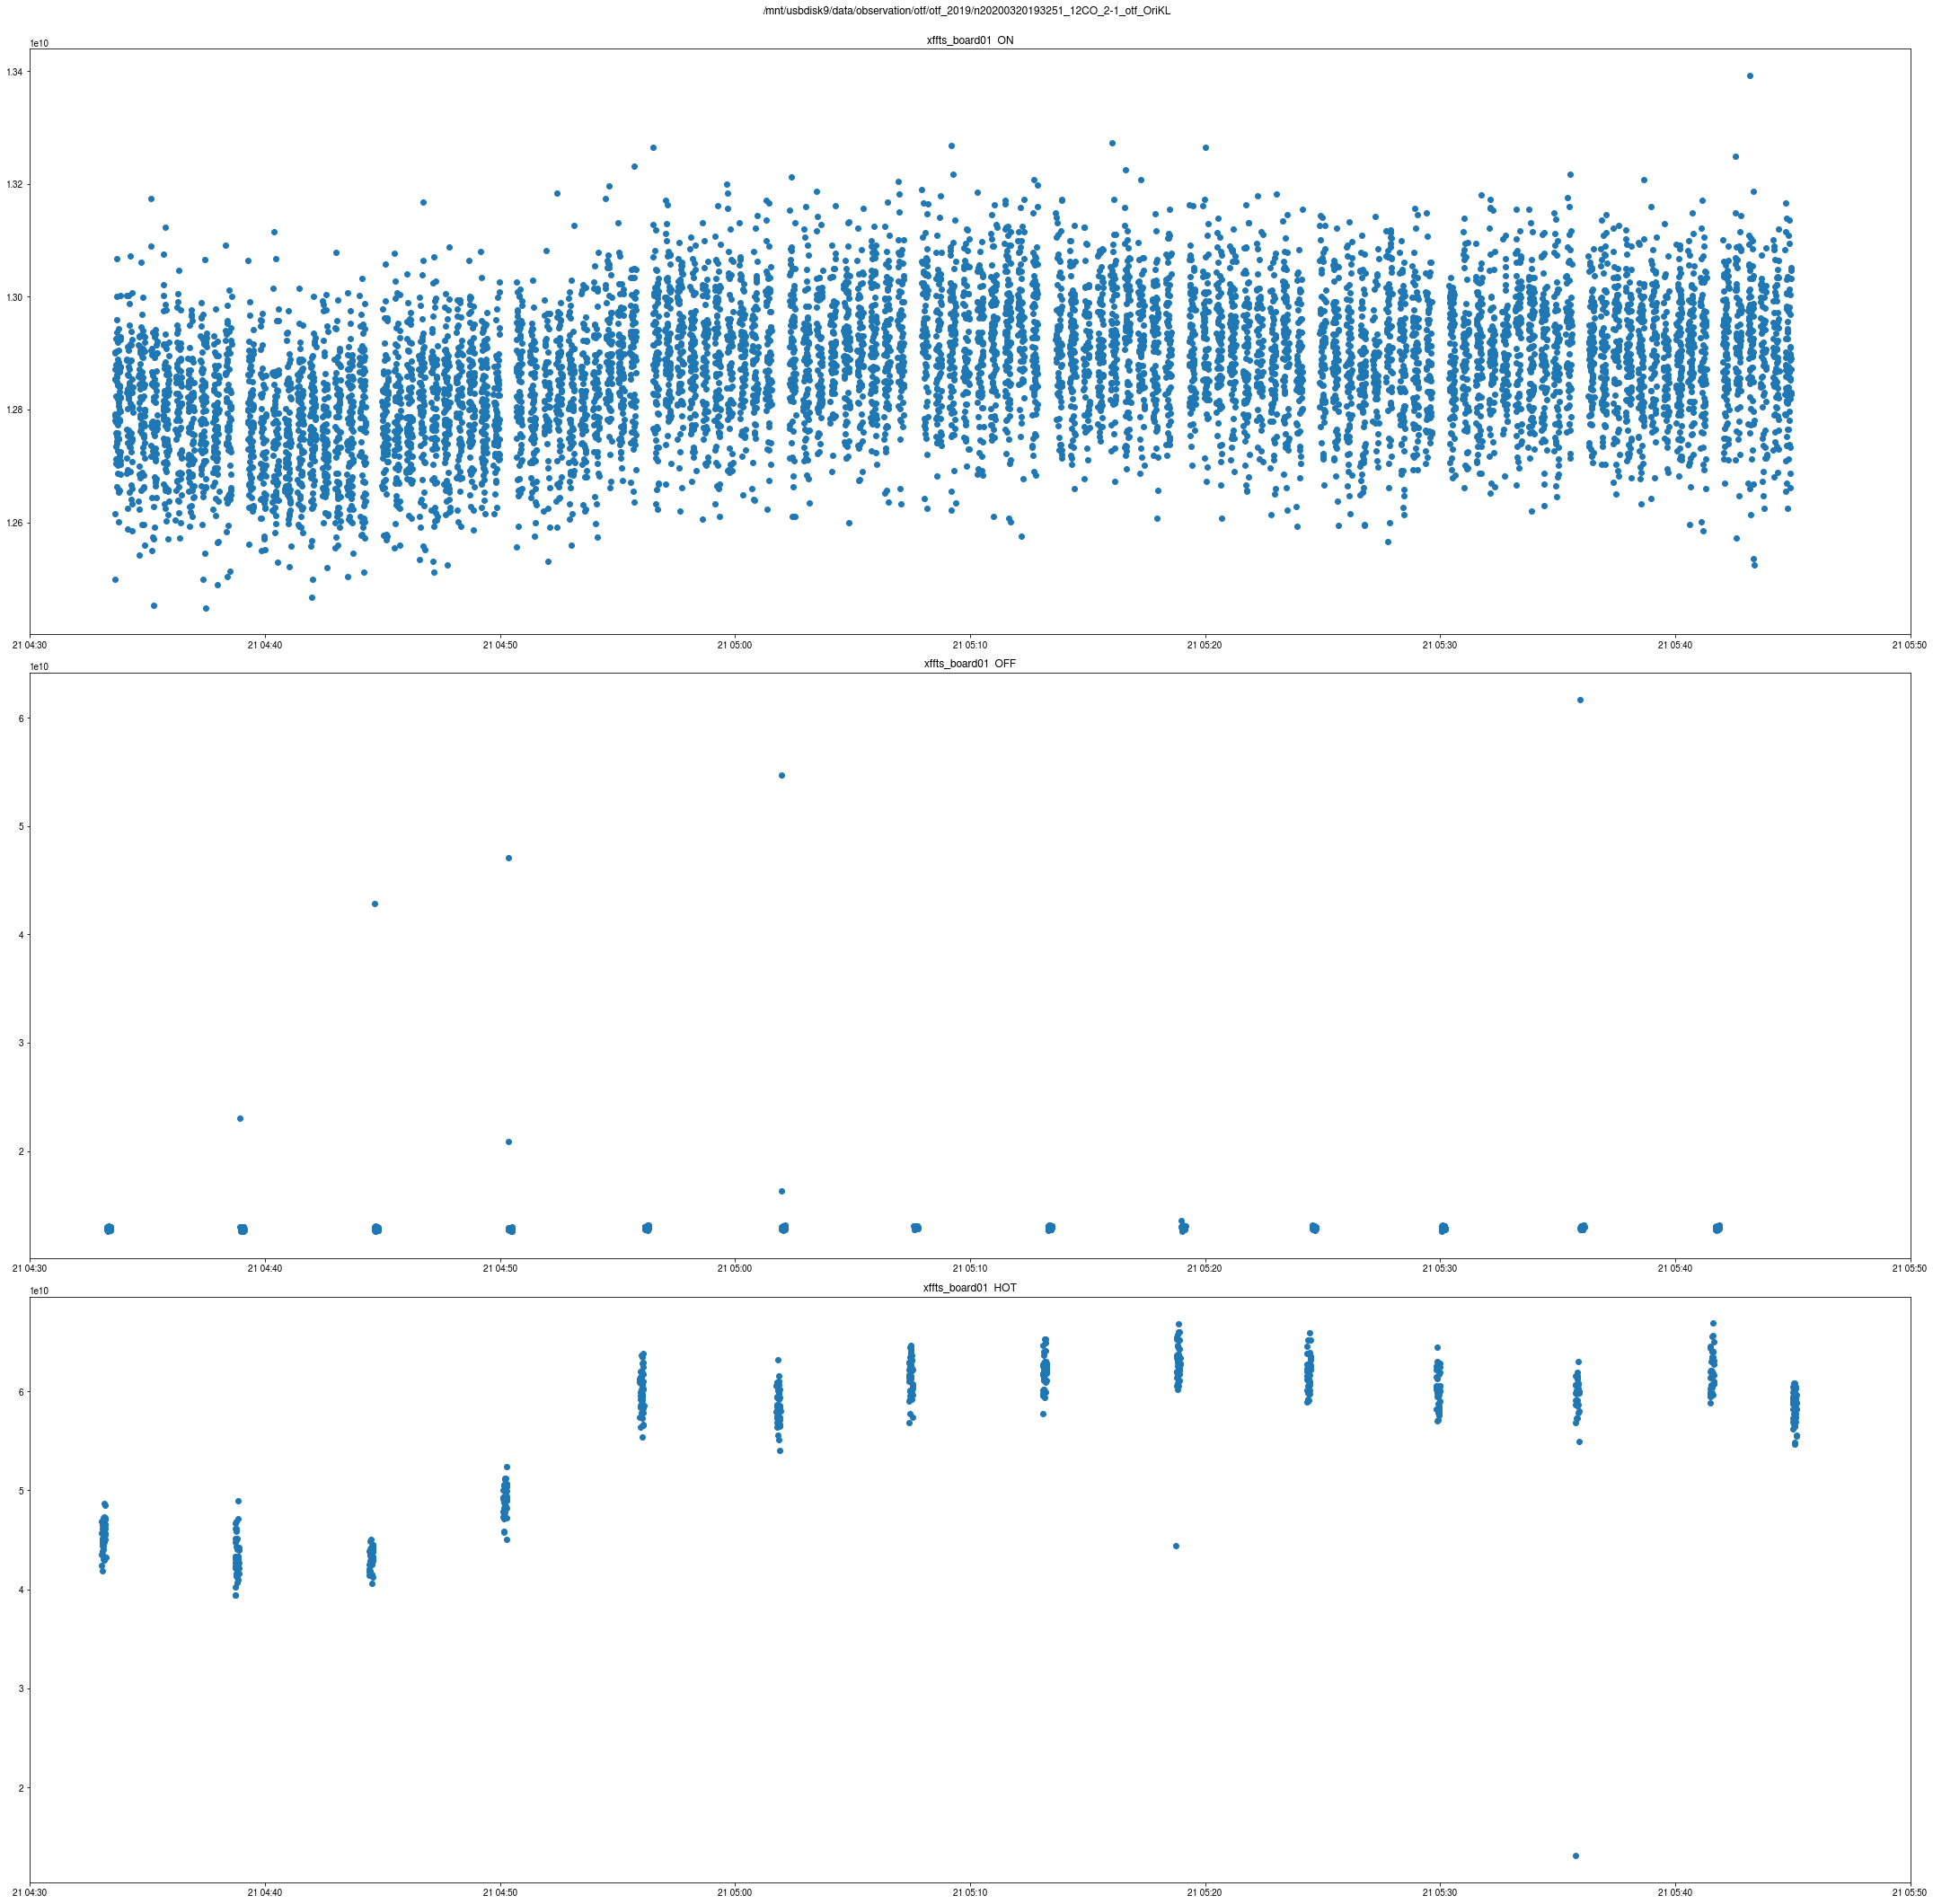

In [33]:
#on,off,hotのグラフ

mainfig = plt.figure(figsize=(30,30))

ax_list = [mainfig.add_subplot(3,1,i+1) for i in range(3)]

name_list=["ON","OFF","HOT"]


for ax, data, name in zip(ax_list, data_list_vs_time,name_list):
    
    ax.scatter(data['time'].values , data.values.T[0])
    
    ax.set_xlim([dt.datetime(2020, 3, 21, 4, 30) , dt.datetime(2020, 3, 21, 5, 50)])
    #ax.set_ylim([data_y.mean() - 1e+17, data_y.mean() + 1e+17])  
    #ax.xaxis.set_major_locator(md.MinuteLocator())
    #ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    ax.set_title(xFFTS_Data_topics[0]+"  "+name)
    

mainfig.suptitle(path)
mainfig.tight_layout(rect=[0,0,1,0.97]) #タイトル , subplotsの調整